# Drizzling WFPC2 Images to use a Single Zeropoint

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

## Introduction

Extra care must be taken when using `AstroDrizzle` to combine observations from detectors comprised of multiple chips of varying sensitivity. `AstroDrizzle` works with calibrated images in units of counts (electrons or Data Numbers) or count rates and not in units of flux. It assumes that all input frames can be converted to physical flux units using a single inverse-sensitivity factor, recorded in the FITS image headers as `PHOTFLAM`, and the output drizzled product simply copies the `PHOTFLAM` keyword value from the first input image. When this occurs, the inverse-sensitivity will vary across the final drizzled product, and users will need to keep track of which sources fell on which chip when doing photometry. Moreover, varying detector sensitivities will affect the cosmic-ray rejection algorithm used by `AstroDrizzle`, and this may result in the misidentification of some good pixels as cosmic rays.

This is a typical situation when drizzle-combining images from HST instruments with different chip sensitivities, e.g. Wide Field and Planetary Camera 2 (WFPC2). For more detail, see the section on [Gain Variation](http://www.stsci.edu/instruments/wfpc2/Wfpc2_dhb/wfpc2_ch53.html) under 'Position-Dependent Photometric Corrections' in the WFPC2 Data Handbook. As a result, each of the four chips requires a [unique PHOTFLAM](http://www.stsci.edu/instruments/wfpc2/Wfpc2_dhb/wfpc2_ch52.html#1933986) header keyword value. A similar situation may occur when drizzle-combining observations taken over a span of several years as detector's sensitivity declines over time, see e.g. [ACS ISR 2016-03](https://doi.org/10.3847/0004-6256/152/3/60).

One approach is to rescale the input data so that `AstroDrizzle` can properly assume the images/chips have the same sensitivity; that is, a single `PHOTFLAM` value can be used to convert re-scaled image counts (or count-rates) to physical _integrated_ flux units. The `photeq` task in `Drizzlepac` automates this image intensity rescaling to a single inverse-sensitivity factor `PHOTFLAM`.

In this example notebook, archival WFPC2 images are used to demonstrate advanced reprocessing using `TweakReg` and `AstroDrizzle` for alignment and image combination. The notebook is based on a prior WFPC2 [example](http://www.stsci.edu/hst/HST_overview/drizzlepac/examples/example7) but includes additional information about equalizing the chip sensitivities prior to combining. 

**NOTE:** It is important to note that `photeq` only adjusts image counts so that _integrated_ physical fluxes can be obtained using a single `PHOTFLAM`. It does nothing to account for different throughtputs at different wavelengths.

In [19]:
import shutil
import glob
import os
import subprocess

import matplotlib.pyplot as plt
from astropy.io import fits

from astroquery.mast import Observations
from stwcs.updatewcs import updatewcs
from drizzlepac import tweakreg, astrodrizzle, photeq
from stsci.skypac import skymatch

# ONLY needed for the simulation section:
import numpy as np
from stwcs.wcsutil import HSTWCS
from drizzlepac.wfpc2Data import WFPC2_GAINS

%matplotlib inline

## 1. Download the Data

This example uses WFPC2 observations of Messier 2 in the F814W filter. The data come from GO proposal [11100](http://www.stsci.edu/cgi-bin/get-proposal-info?id=11100&observatory=HST) _"Two new 'bullets' for MOND: revealing the properties of dark matter in massive merging clusters"_. Four images were acquired using a 4-pt dither box pattern, followed by two images offset with a dither-line pattern. 

The data are downloaded using the `astroquery` API to access the [MAST](http://archive.stsci.edu) archive. The `astroquery.mast` [documentation](http://astroquery.readthedocs.io/en/latest/mast/mast.html) has more examples for how to find and download data from MAST.

In [20]:
# Retrieve the observation information.
if os.path.isdir('mastDownload'):
    shutil.rmtree('mastDownload')
#obs_table = Observations.query_criteria(obs_id='ua0605*', filters='F814W', obstype='ALL')
obs_table = Observations.query_criteria(obs_collection='HST', proposal_id=['10424'],filters='F336W')

products = Observations.get_product_list(obs_table)

# Download only the ua0605*_c0m.fits and ua0605*_c1m.fits (DQ) images:
Observations.download_products(products, mrp_only=False, productSubGroupDescription=['C0M', 'C1M'], extension='fits')

# Move the files from the mastDownload directory to the current working
# directory and make a backup of the files.
fits_files = glob.glob('mastDownload/HST/u*/u*c?m.fits')
for fil in fits_files:
    base_name = os.path.basename(fil)
    if os.path.isfile(base_name):
        os.remove(base_name)
    shutil.move(fil, '.')
    
# Delete the mastDownload directory and all subdirectories it contains.
shutil.rmtree('mastDownload')

## 2. Update the WCS

WFPC2 images downloaded from the archive contain World Coordinate System (WCS) information based on an older-style description of image distortions. Before these images can be processed with `drizzlepac`, their WCS must be converted to a new format. This can be achieved using `updatewcs()` function from the `stwcs` package. More details may be found here: ['Making WFPC2 Images Compatible with AstroDrizzle'](http://documents.stsci.edu/hst/HST_overview/documents/DrizzlePac/ch45.html#601857). Note that `updatewcs` is no longer a parameter in AstroDrizzle or TweakReg and must be run separately before processing the data. 

First we download the reference files from the CRDS website. See the initialization notebook in this repository for more information.  

In [21]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = os.path.abspath(os.path.join('.', 'reference_files'))

subprocess.check_output('crds bestrefs --files *c0m.fits --sync-references=1 --update-bestrefs', shell=True)

#
os.environ['uref'] = os.path.abspath(os.path.join('.', 'reference_files', 'references', 'hst', 'wfpc2')) + os.path.sep

In [22]:
! echo $uref

/home/mmarcano/Documents/NGC6397F336W/NGC6397/reference_files/references/hst/wfpc2/


**NOTE:** This next step may raise warnings because the Astrometry database is in progress and currently does not cover the entire sky. Please ignore these warnings. The WCS will still be updated.  

In [23]:
updatewcs('u*c0m.fits', True)

- IDCTAB: Distortion model from row 354 for chip 3 : F336W
- OFFTAB: Offset interpolated from rows 27 and 31
- IDCTAB: Distortion model from row 22 for chip 1 : F336W
- OFFTAB: Offset interpolated from rows 25 and 29
- IDCTAB: Distortion model from row 188 for chip 2 : F336W
- OFFTAB: Offset interpolated from rows 26 and 30
- IDCTAB: Distortion model from row 354 for chip 3 : F336W
- OFFTAB: Offset interpolated from rows 27 and 31
- IDCTAB: Distortion model from row 520 for chip 4 : F336W
- OFFTAB: Offset interpolated from rows 28 and 32
- IDCTAB: Distortion model from row 354 for chip 3 : F336W
- OFFTAB: Offset interpolated from rows 27 and 31
- IDCTAB: Distortion model from row 22 for chip 1 : F336W
- OFFTAB: Offset interpolated from rows 25 and 29
- IDCTAB: Distortion model from row 188 for chip 2 : F336W
- OFFTAB: Offset interpolated from rows 26 and 30
- IDCTAB: Distortion model from row 354 for chip 3 : F336W
- OFFTAB: Offset interpolated from rows 27 and 31
- IDCTAB: Distortion 

['u9710103m_c0m.fits',
 'u9710106m_c0m.fits',
 'u9710109m_c0m.fits',
 'u9710203m_c0m.fits',
 'u9710206m_c0m.fits',
 'u9710209m_c0m.fits',
 'u9710303m_c0m.fits',
 'u9710306m_c0m.fits',
 'u9710403m_c0m.fits',
 'u9710406m_c0m.fits',
 'u9710503m_c0m.fits',
 'u9710506m_c0m.fits',
 'u9710603m_c0m.fits',
 'u9710606m_c0m.fits',
 'u9710703m_c0m.fits',
 'u9710706m_c0m.fits',
 'u9710803m_c0m.fits',
 'u9710806m_c0m.fits',
 'u9710903m_c0m.fits',
 'u9710906m_c0m.fits',
 'u9711003m_c0m.fits',
 'u9711006m_c0m.fits',
 'u9711103m_c0m.fits',
 'u9711106m_c0m.fits',
 'u9711203m_c0m.fits',
 'u9711206m_c0m.fits',
 'u9711209m_c0m.fits',
 'u971120cm_c0m.fits',
 'u971120fm_c0m.fits',
 'u9711303m_c0m.fits',
 'u9711306m_c0m.fits',
 'u9711309m_c0m.fits',
 'u971130cm_c0m.fits',
 'u971130fm_c0m.fits',
 'u9711403m_c0m.fits',
 'u9711406m_c0m.fits',
 'u9711409m_c0m.fits',
 'u971140cm_c0m.fits',
 'u971140fm_c0m.fits',
 'u9711503m_c0m.fits',
 'u9711506m_c0m.fits',
 'u9711509m_c0m.fits',
 'u971150cm_c0m.fits',
 'u971150fm

### Backup an Image

In a later section we will generate simulated data to illustrate the effects of drizzling WFPC2 images without sensitivity equalization. For that purpose we will need a copy of an original image that has the original inverse-sensitivity values (`PHOTFLAM`) in their headers. Here we create a backup copy of the first image.

**NOTE:** This step is needed for illustration purpose in this notebook only. It is not needed when processing data.

In [24]:
orig_image = glob.glob('u*c0m.fits')[0]
backup_image = 'simulation.fits'
if os.path.isfile(backup_image):
    os.remove(backup_image)
shutil.copy2(orig_image, backup_image)

## 3. Align the Images

Due to small pointing errors, the image header WCS typically needs to be updated in order to achieve the best drizzle-combined products. The expected pointing accuracy for various observing scenerios is summarized in the DrizzlePac Handbook [Appendix B](http://documents.stsci.edu/hst/HST_overview/documents/DrizzlePac/AppendixB2.html). Input images must first be aligned so that when the coordinates of a given object (in detector space) are converted to sky coordinates (using the WCS), that object's sky coordinates must be approximately equal in each frame. 

The `DrizzlePac` task `TweakReg` may be used to correct for any errors in the image header WCS. First, `TweakReg` finds sources in each image, matches sources in common across images, and finds a separate linear transformation to align each image. `TweakReg` then computes a new WCS for each image based on this linear transformation.

Here we show a basic image alignment procedure. For a more detailed illustration of image alignment, please refer to other example notebooks such as the mosaic example in this repository.

Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 15:49:48.289 (24/05/2019) 

Version Information
--------------------
Python Version [GCC 7.3.0]
2.7.16 |Anaconda, Inc.| (default, Mar 14 2019, 21:00:58) 
numpy Version -> 1.16.3 
astropy Version -> 2.0.9 
stwcs Version -> 1.3.2 

Finding shifts for: 
    u9710103m_c0m.fits
    u9710106m_c0m.fits
    u9710109m_c0m.fits
    u9710203m_c0m.fits
    u9710206m_c0m.fits
    u9710209m_c0m.fits
    u9710303m_c0m.fits
    u9710306m_c0m.fits
    u9710403m_c0m.fits
    u9710406m_c0m.fits
    u9710503m_c0m.fits
    u9710506m_c0m.fits
    u9710603m_c0m.fits
    u9710606m_c0m.fits
    u9710703m_c0m.fits
    u9710706m_c0m.fits
    u9710803m_c0m.fits
    u9710806m_c0m.fits
    u9710903m_c0m.fits
    u9710906m_c0m.fits
    u9711003m_c0m.fits
    u9711006m_c0m.fits
    u9711103m_c0m.fits
    u9711106m_c0m.fits
    u9711203m_c0m.fits
    u9711206m_c0m.fits
    u9711209m_c0m.fits
    u971120cm_c0m.fits
    u971120fm_c0m.fi

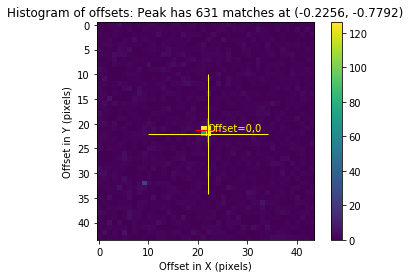

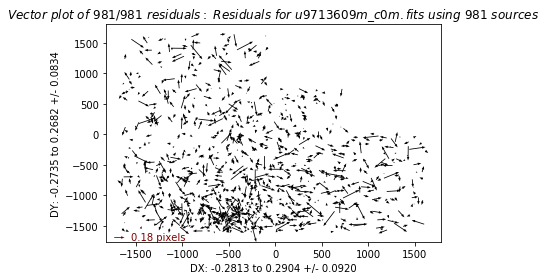

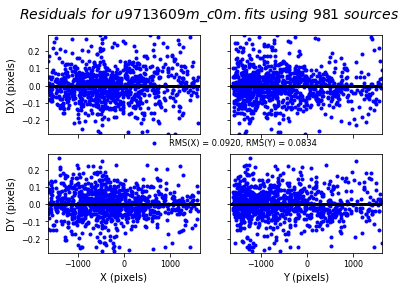

In [25]:
tweakreg.TweakReg('u*c0m.fits', updatehdr=True, reusename=True, interactive=False,
                  conv_width=3.0, threshold=300.0, peakmin=100, peakmax=10000)

## 4. Equalize the chip sensitivities

This step adjusts image data values so that all images and chips appear (to `AstroDrizzle`) to have a single inverse sensitivity (`PHOTFLAM`). This can be achieved using the `photeq` task in `Drizzlepac`. This task adjusts image data so that when these data are multiplied by the same single `PHOTFLAM` value, the correct flux is obtained.

In [26]:
photeq.photeq(files='u*_c0m.fits', ref_phot_ext=3, readonly=False)

***** drizzlepac.photeq started on 2019-05-24 15:58:55.848777
      Version 0.2 (06-Nov-2015)

PRIMARY PHOTOMETRIC KEYWORD: PHOTFLAM
SECONDARY PHOTOMETRIC KEYWORD(S): PHOTFNU
REFERENCE VALUE FROM FILE: 'u9710103m_c0m.fits[3]'
REFERENCE 'PHOTFLAM' VALUE IS: 5.451384e-17

Processing file 'u9710103m_c0m.fits'
   * EXT: ('SCI', 1)
     - Setting PHOTFLAM to 5.451384e-17 (old value was 5.613531e-17)
     - Computed conversion factor for data: 1.02974418973
     - Data have been multiplied by 1.02974418973
   * EXT: ('SCI', 2)
     - Setting PHOTFLAM to 5.451384e-17 (old value was 5.44483e-17)
     - Computed conversion factor for data: 0.998797736501
     - Data have been multiplied by 0.998797736501
   * EXT: ('SCI', 3) - This is the "reference" extension.
          Nothing to do. Skipping this extension...
   * EXT: ('SCI', 4)
     - Setting PHOTFLAM to 5.451384e-17 (old value was 5.590183e-17)
     - Computed conversion factor for data: 1.02546124067
     - Data have been multiplied by 1

In the above command, we instruct `photeq` to "equalize" all chips of all input images using the `PHOTFLAM` for the `WF3` chip (`ref_phot_ext=3`), using the first image as a reference. This reference `PHOTFLAM` value is reported in the log file:

```
REFERENCE VALUE FROM FILE: 'ua060502m_c0m.fits['SCI',1]'
REFERENCE 'PHOTFLAM' VALUE IS: 2.507987e-18
```

Upon the completion, `photeq` will not only adjust image data but also update `PHOTFLAM` values for all chips to this specific reference value.

## 5. Drizzle-combine the images

All four chips are now drizzled together with an output pixel scale set to that of the WF chips:

In [27]:
astrodrizzle.AstroDrizzle('u*c0m.fits',
                          preserve=False,
                          driz_sep_bits='8,1024',
                          driz_sep_wcs=True,
                          driz_sep_scale=0.0996,
                          combine_type='median',
                          driz_cr_snr='5.5 3.5',
                          driz_cr_scale='2.0 1.5',
                          final_fillval=None,
                          final_bits='8,1024',
                          final_wcs=True,
                          final_scale=0.0996)

Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 15:59:19.469 (24/05/2019)

==== Processing Step  Initialization  started at  15:59:19.474 (24/05/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 265.1476352093491  -53.66660702608216  
CRPIX : 775.1035742971889  764.1363453815262  
CD1_1 CD1_2  : -1.96651093353158e-05  -1.9460933155286254e-05  
CD2_1 CD2_2  : -1.9460933155286254e-05  1.96651093353158e-05  
NAXIS : 1549  1527
********************************************************************************
*
*  Estimated memory usage:  up to 1533 Mb.
*  Output image size:       1549 X 1527 pixels. 
*  Output image file:       ~ 27 Mb. 
*  Cores available:         48
*
********************************************************************************
==== Processing Step  Initialization  finished at  16:01:28.036 (24/05/2019)

==== Processing Step  Static Mask  started at  16:01:28.041 (24/05/2019)
===

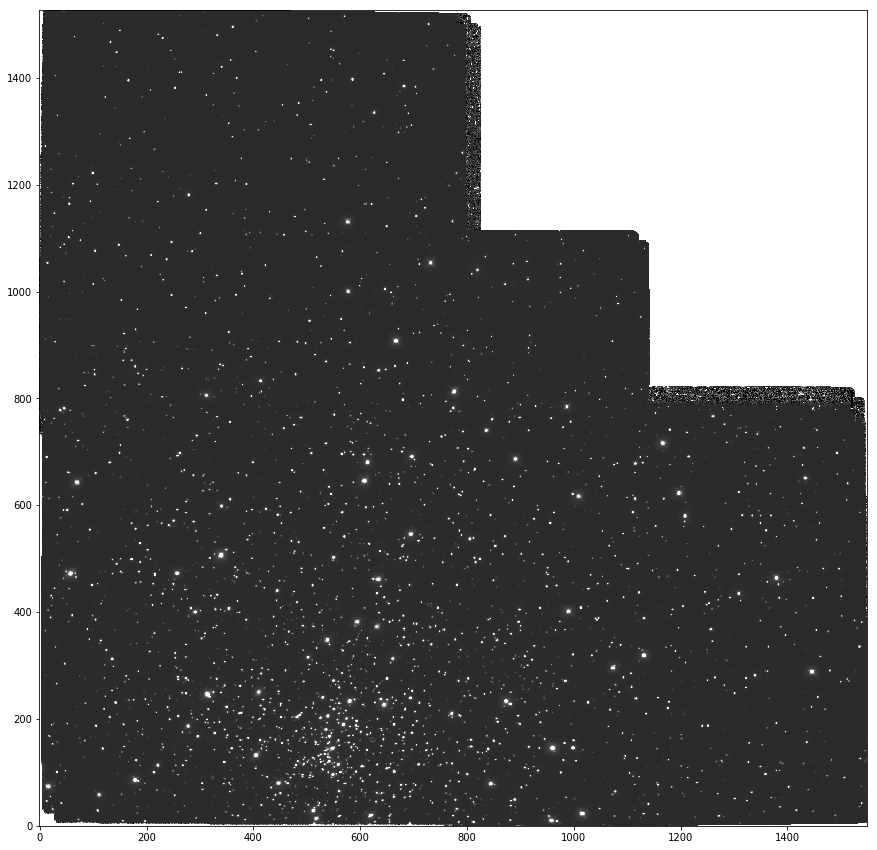

In [28]:
drz = fits.getdata('final_drz_sci.fits')
plt.figure(figsize=(15, 15))
plt.imshow(drz, cmap='gray', vmin=-0.1, vmax=0.5, origin='lower')

# Individual image


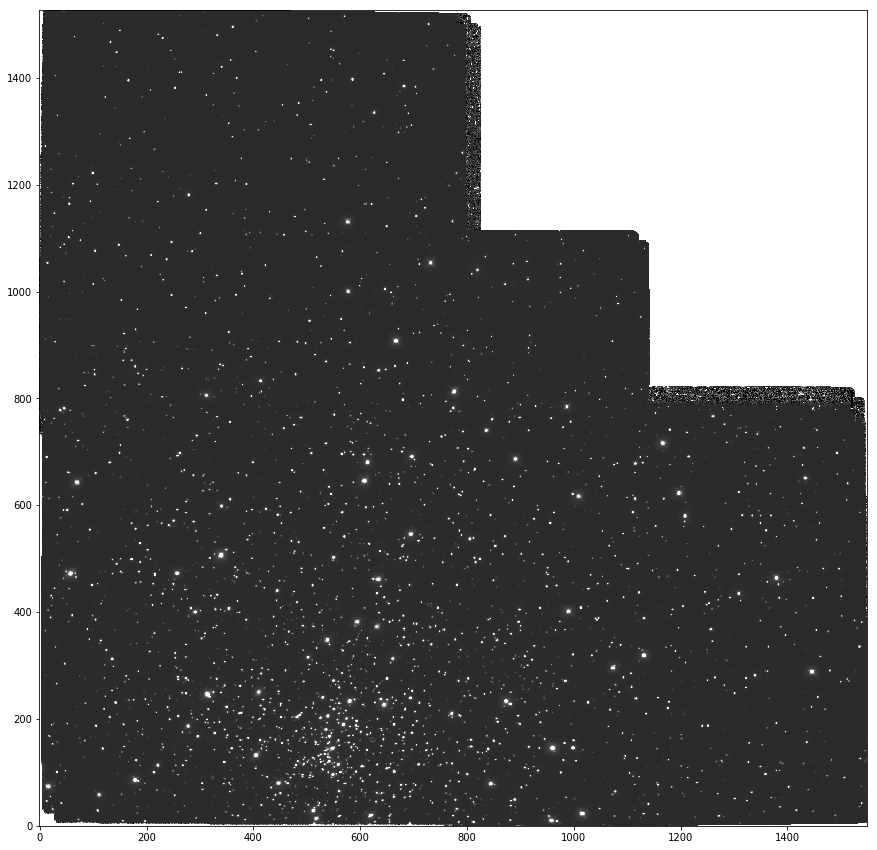

In [29]:
singlename = 'u9712903m_c0m_single_sci.fits'
single = fits.getdata(singlename)
plt.figure(figsize=(15, 15))
plt.imshow(drz, cmap='gray', vmin=-0.1, vmax=0.5, origin='lower')

## Cosmic Rays

If there are a lot of cosmic rays in a small set of input images, some sources may be misidentified as cosmic rays, resulting in those PSFs having chopped-off peaks. Try adjusting the combine_nsigma, combine_nlow and combine_nhigh AstroDrizzle parameter values to get more optimal cosmic ray rejection parameter values for your images. 

In [ ]:
astrodrizzle.AstroDrizzle('u*c0m.fits',
                          preserve=False,
                          driz_sep_bits='8,1024',
                          driz_sep_wcs=True,
                          driz_sep_scale=0.0996,
                          combine_type='median',
                          driz_cr_snr='5.5 3.5',
                          driz_cr_scale='2.0 1.5',
                          final_fillval=None,
                          final_bits='8,1024',
                          final_wcs=True,
                          final_scale=0.0996,
                          combine_nsigma=,
                          combine_nlow=,
                          combine_nhigh=
                         )

# About this Notebook

Based on notebook by 

    Author: M. Cara, STScI Data Analysis Tools Branch
    Updated: December 14, 2018